# 10. Actor-Critic

## 10.1 Intro

## 10.2. Actor-Critic

$g = \mathbb{E}\left[\sum_{t=0}^T\psi_t\nabla_\theta\log\pi_\theta(a_t|s_t)\right]$

$\psi_t$的形式
1. $\sum_{t'=0}^T\gamma^{t'}r_{t'}$: 轨迹总回报
2. $\sum_{t'=0}^T\gamma^{t' - t}r_{t'}$: 动作$a_t$之后的回报
3. $\sum_{t'=0}^T\gamma^{t'}r_{t'} - b(s_t)$: 基线版本改进
4. $Q^{\pi_\theta}(s_t, a_t)$: 动作价值函数
5. $A^{\pi_\theta}(s_t, a_t)$: 优势函数
6. $r_t + \gamma V^{\pi_\theta}(s_{t+1}) - V^{\pi_\theta}(s_t)$: 时序差分残差

时序差分损失函数：
$$
\mathcal{L}(\omega) = \frac12(r + \gamma V_\omega(s_{t+1}) - V_\omega(s_t))^2
$$
梯度：
$$
\mathcal{L}(\omega) = -(r + \gamma V_\omega(s_{t+1}) - V_\omega(s_t))\nabla_\omega V_\omega(s_t)
$$

算法：
伪代码 AC：
1. 随机初始化策略网络参数$\theta$和价值网络参数$\omega$
2. **for**  $e = 1 \rightarrow E$ **do**:
   1. 用当前策略$\pi_\theta$采样轨迹 $\left\{s_1, a_1, r_1, s_2, a_2, r_2, ..., ..., s_T, a_T, r_T\right\}$
   2. 为每一步计算数据：$\delta_t = r_t + \gamma V_\omega(s_{t + 1}) - V_\omega(s_t)$
   3. 更新价值参数 $\omega \leftarrow \omega + \alpha_\omega\sum_t\delta_t\nabla_\omega V_\omega(s_t)$
   4. 更新策略参数：$\theta \leftarrow \theta + \alpha_\theta\sum_{t}\delta_t\nabla_\theta\log\pi_\theta(a_t|s_t)$
3. **end for**


In [11]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
from tqdm import tqdm
import matplotlib.pyplot as plt
import rl_utils

In [12]:
class PolicyNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return F.softmax(self.fc2(x), dim=1)

In [13]:
class ValueNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim):
    super(ValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return self.fc2(x)

In [14]:
class ActorCritic:
  def __init__(self, state_dim, hidden_dim, action_dim, 
              actor_lr, critic_lr, gamma,
              device):
    # 策略网络
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.device = device
    
  def take_action(self, state): # 根据动作概率分布随机采样
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    
    
    # 时序差分目标
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    td_delta = td_target - self.critic(states)
    log_probs = torch.log(self.actor(states).gather(1, actions))
    actor_loss = torch.mean(-log_probs * td_delta.detach())
    # 均方误差损失
    critic_loss = torch.mean(
      F.mse_loss(self.critic(states), td_target.detach())
    )
    self.actor_optimizer.zero_grad()
    self.critic_optimizer.zero_grad() 
    actor_loss.backward()
    critic_loss.backward()
    self.actor_optimizer.step()
    self.critic_optimizer.step()

In [15]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent =ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, episode=1000, return=500.000]


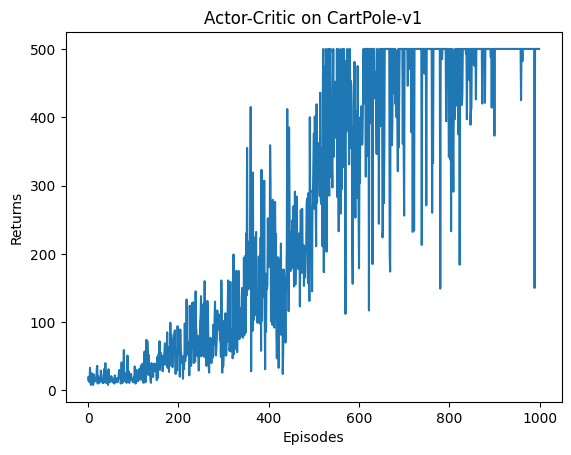

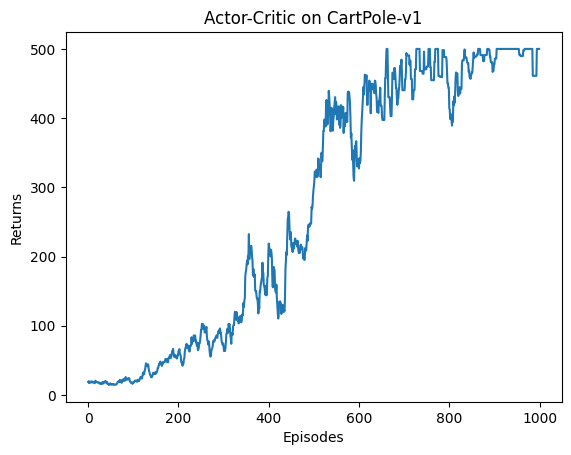

In [16]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()